<a href="https://colab.research.google.com/github/aghakishiyeva/creating-adversarial-patch/blob/main/AIPI590_Assignment_2_Adversarial_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [6]:
## Standard libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import transforms

# Libraries and Path to the folder where datasets and models are saved
import urllib.request
from urllib.error import HTTPError
import zipfile
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting up the device (CPU or GPU)
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


<ipython-input-6-a6166403dcbd>:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


# Downloading Required Files

In [7]:
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

# Load Pretrained Model

In [8]:
# Load pretrained ResNet34 model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
pretrained_model.eval()  # Set to evaluation mode
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 37.9MB/s]


# Dataset and DataLoader Setup

In [9]:
# ImageNet normalization
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# Image transformations
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# Load TinyImageNet dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8)

# Load label names
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Function to Place Patch on Image

In [10]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[2] - 1)
        img[i, :, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = patch
    return img

# Mapping Patch Values to Image Range

In [11]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]

def patch_forward(patch):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

# Evaluation Function

In [12]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp / counter
    top5 = tp_5 / counter
    return acc, top5

# Patch Training Loop

In [13]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)

    patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for img, _ in tqdm(train_loader, leave=False):
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [21]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [22]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [23]:
class_names = ['toaster', 'goldfish', 'school bus', 'lipstick', 'pineapple']
patch_sizes = [32, 48, 64]

patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

<ipython-input-22-44e714ff96fe>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(file_name)


# Visualization of Patch Attack

In [24]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, 0.0, 1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].axis('off')
    plt.show()

# Perform Patch Attack

In [28]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()  # Clone the batch of images
    patch_batch = place_patch(patch_batch, patch)  # Apply the patch to the batch

    with torch.no_grad():  # Disable gradient calculation for inference
        patch_preds = pretrained_model(patch_batch.to(device))  # Get predictions for patched images

    # Display the first few patched images and their predictions
    for i in range(4):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])


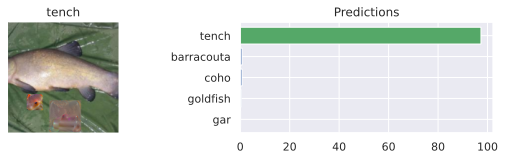

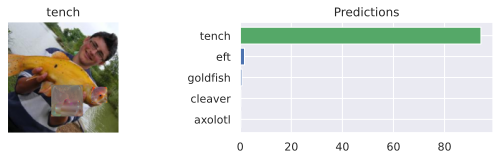

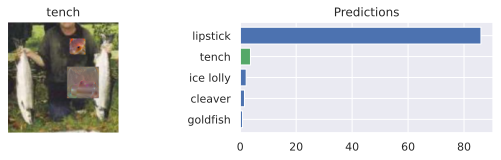

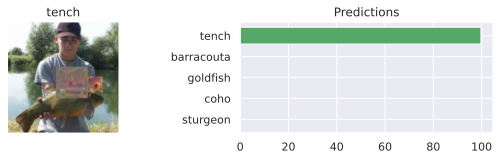

In [29]:
def perform_patch_attack_two_patches(patch1, patch2):
    patch_batch = exmp_batch.clone()  # Clone the batch of images

    # Apply the first patch
    patch_batch = place_patch(patch_batch, patch1)

    # Apply the second patch (you may want to ensure the second patch is placed in a different location)
    patch_batch = place_patch(patch_batch, patch2)

    with torch.no_grad():  # Disable gradient calculation for inference
        patch_preds = pretrained_model(patch_batch.to(device))  # Get predictions for patched images

    # Display the first few patched images and their predictions
    for i in range(4):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

# Example usage:
perform_patch_attack_two_patches(patch_dict['goldfish'][32]['patch'], patch_dict['lipstick'][64]['patch'])

# Show Predictions with Patch Applied

In [26]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, 0.0, 1.0)
        label = label.item()

    fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[1].barh(np.arange(K), topk_vals*100.0, color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[1].set_yticks(np.arange(K))
    ax[1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[1].invert_yaxis()
    ax[1].set_title('Predictions')
    plt.show()

# Running Patch Attack

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


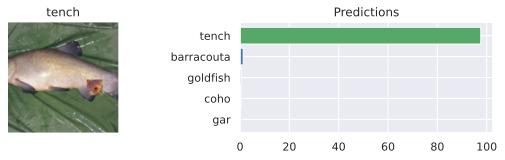

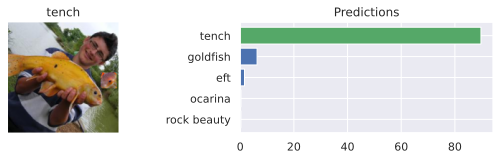

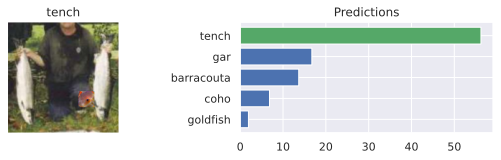

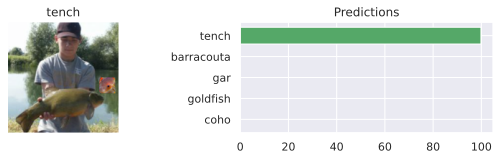

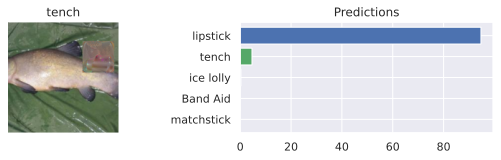

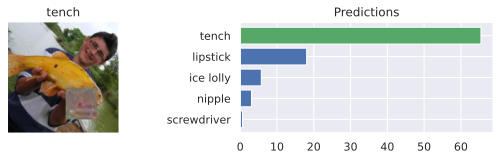

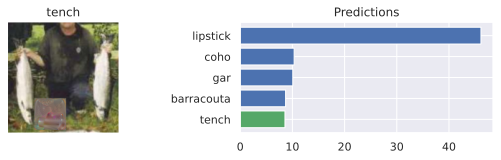

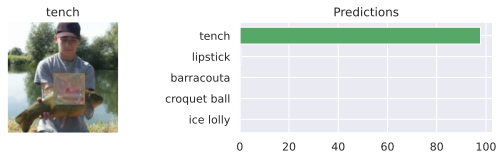

In [27]:
exmp_batch, label_batch = next(iter(data_loader))
perform_patch_attack(patch_dict['goldfish'][32]['patch'])
perform_patch_attack(patch_dict['lipstick'][64]['patch'])